In [1]:
# ID2024102315041145680199
# 列抽样算法对 acc_sel 的影响，禁用行抽样
import os.path
import pandas as pd
from tshpo.lib_class import AnaHelper

_file = AnaHelper.prepare_csv("c05_effect_of_sample_method_v2_original_20241025_0812.csv.gz", return_df=False)
_generate_file = f"{_file}_acc.gz"
if not os.path.exists(_generate_file):
    _odf = pd.read_csv(_file)
    _odf['metric'] = "accuracy"
    _odf.to_csv(_generate_file)
df = pd.concat([
    AnaHelper.load_acc_select(os.path.basename(_file), alpha=0.005),
    AnaHelper.load_acc_select(os.path.basename(_generate_file), alpha=0.005)])
df

Parse configs


  0%|          | 0/240 [00:00<?, ?it/s]

Parse configs


100%|██████████| 240/240 [00:32<00:00,  7.31it/s]


Parse configs


100%|██████████| 240/240 [00:08<00:00, 29.57it/s]


,top_n,acc,dataset,metric,fsm,fsr,dsm,dsr,n_exploration,hpo_opt_method
0,1,1,pc4,roc_auc,RF,1,Halton,0.1,30,rs
1,2,1,pc4,roc_auc,RF,1,Halton,0.1,30,rs
2,3,1,pc4,roc_auc,RF,1,Halton,0.1,30,rs
3,4,1,pc4,roc_auc,RF,1,Halton,0.1,30,rs
4,5,1,pc4,roc_auc,RF,1,Halton,0.1,30,rs
...,...,...,...,...,...,...,...,...,...,...
1915,4,1,phoneme,accuracy,RF,1,Stratified,0.8,30,rs
1916,5,1,phoneme,accuracy,RF,1,Stratified,0.8,30,rs
1917,6,1,phoneme,accuracy,RF,1,Stratified,0.8,30,rs
1918,7,1,phoneme,accuracy,RF,1,Stratified,0.8,30,rs


In [2]:
df[(df['acc'] != 1) & (df['dsm'] == "RS") & (df['top_n'] == 4)]

,top_n,acc,dataset,metric,fsm,fsr,dsm,dsr,n_exploration,hpo_opt_method
387,4,0,kc1,roc_auc,RF,1,RS,0.1,30,rs
1667,4,0,churn,roc_auc,RF,1,RS,0.1,30,rs
227,4,0,pc3,accuracy,RF,1,RS,0.1,30,rs


In [3]:
datasets = df['dataset'].drop_duplicates().tolist()
datasets

['pc4',
 'pc3',
 'kc1',
 'ozone-level-8hr',
 'madelon',
 'kr-vs-kp',
 'Bioresponse',
 'sick',
 'spambase',
 'wilt',
 'churn',
 'phoneme']

In [4]:
df = df[df['top_n'] < 7]
adf = df.groupby(by=['top_n', 'metric', 'fsm', 'fsr', 'dsm', 'dsr', 'n_exploration', 'hpo_opt_method'])[
          'acc'].sum() / len(datasets)
adf = adf.reset_index()
adf['metric'] = adf['metric'].apply(lambda x: AnaHelper.normal_metric_name(x))
adf

,top_n,metric,fsm,fsr,dsm,dsr,n_exploration,hpo_opt_method,acc
0,1,Accuracy,RF,1,Halton,0.1,30,rs,0.583333
1,1,Accuracy,RF,1,Halton,0.3,30,rs,0.750000
2,1,Accuracy,RF,1,Halton,0.5,30,rs,0.916667
3,1,Accuracy,RF,1,Halton,0.8,30,rs,0.833333
4,1,Accuracy,RF,1,LHS,0.1,30,rs,0.416667
...,...,...,...,...,...,...,...,...,...
235,6,ROC AUC,RF,1,Sobol,0.8,30,rs,1.000000
236,6,ROC AUC,RF,1,Stratified,0.1,30,rs,1.000000
237,6,ROC AUC,RF,1,Stratified,0.3,30,rs,1.000000
238,6,ROC AUC,RF,1,Stratified,0.5,30,rs,1.000000


In [6]:
from matplotlib.ticker import FormatStrFormatter
import matplotlib.pyplot as plt
import seaborn as sns


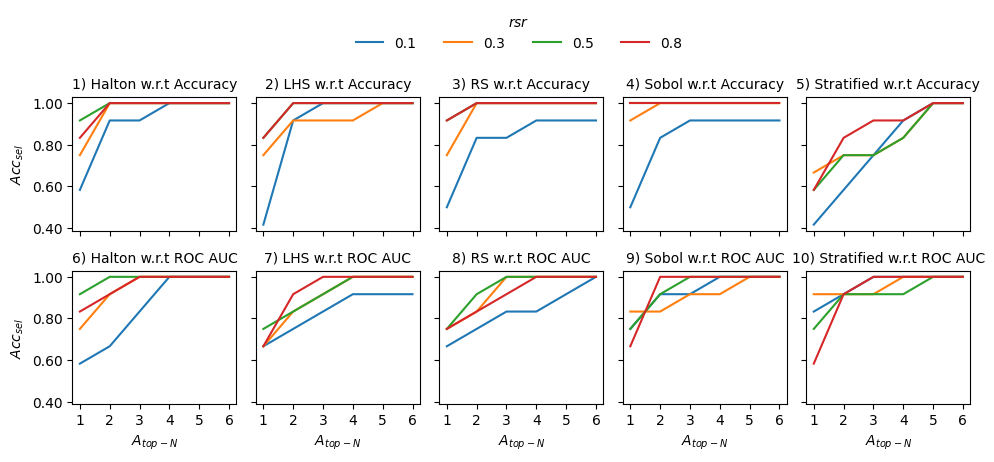

In [7]:
# ID2024112716431501827525
from tshpo.ana_libs import PaperLabel
# 行（row）抽样算法对精度的影响, 禁用列抽样
import warnings

warnings.filterwarnings("ignore")
_plot_df1 = adf[(adf['metric'] != "f1")
                & (adf['fsm'] == "RF")
                & (adf['fsr'] == 1)
                & (adf['n_exploration'] == 30)
                ]
g = sns.FacetGrid(_plot_df1, col="dsm", row="metric", height=2, aspect=1, despine=False, sharey=True)
g.map_dataframe(sns.lineplot, x='top_n', y='acc', hue='dsr', palette=sns.color_palette())
counter = 0
ax = None
for (_dsm, _metric), ax in g.axes_dict.items():
    counter += 1
    ax = ax
    # ax.set_title(f"{counter}) {ax.get_title()}".replace("dsm","rsm").replace("dsr","rsr"))
    ax.set_title(f"{counter}) {_metric} w.r.t {_dsm}", fontsize=10)
    # if ax.get_title().find("AUC")>-1:
    #     ax.set_ylim(0.65,1.01)
    # else:
    # ax.set_ylim(0.4,1.01)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
    if ax.get_xlabel() != "":
        ax.set_xlabel(PaperLabel.TOP_N_SELECTED_ALGORITHMS)
    if ax.get_ylabel() != "":
        ax.set_ylabel(PaperLabel.ACC_SELECT)
    ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
    ax.grid(False)
    ax.set_xticks([1, 2, 3, 4, 5, 6], [1, 2, 3, 4, 5, 6])
    ax.yaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))
    ax.grid(False)
    # handles, labels = ax.get_legend_handles_labels()
    # ax.legend(handles, labels, title="$rsr$")
handles, labels = ax.get_legend_handles_labels()
g.add_legend(handles=handles, labels=labels, title="$rsr$", loc="upper center", bbox_to_anchor=(0.4, 1.15), ncol=4)
g.savefig(f"effect_row_sampling.pdf", bbox_inches='tight')

In [8]:
_plot_df1[_plot_df1['dsm'] == 'RS']

,top_n,metric,fsm,fsr,dsm,dsr,n_exploration,hpo_opt_method,acc
8,1,Accuracy,RF,1,RS,0.1,30,rs,0.500000
9,1,Accuracy,RF,1,RS,0.3,30,rs,0.750000
10,1,Accuracy,RF,1,RS,0.5,30,rs,0.916667
11,1,Accuracy,RF,1,RS,0.8,30,rs,0.916667
28,1,ROC AUC,RF,1,RS,0.1,30,rs,0.666667
29,1,ROC AUC,RF,1,RS,0.3,30,rs,0.750000
30,1,ROC AUC,RF,1,RS,0.5,30,rs,0.750000
31,1,ROC AUC,RF,1,RS,0.8,30,rs,0.750000
48,2,Accuracy,RF,1,RS,0.1,30,rs,0.833333
49,2,Accuracy,RF,1,RS,0.3,30,rs,1.000000


In [9]:
df = pd.read_csv(_file)
df

,Unnamed: 0,id,default_max,default_min,status,#instances,model_training_time,data_processing_time,walk_time,configs_and_metrics,...,max_iteration,model_name,is_trim_sp,n_high_performing_model,n_samples_for_each_model,hpo_opt_method,max_samples,n_exploration,data_sample_method,data_sample_rate
0,0,7642dbc54b2042020a3be883a9dd5ef3,0.8077,0.0890,success,420,80.4923,0.0182,81.30,[(Configuration(values={\n '__choice__': 'ada...,...,NaN,NaN,False,14,NaN,rs,NaN,30,Halton,0.1
1,0,754219ea15ebe54ad930aec41eb0eed8,0.8095,0.0582,success,420,126.3221,0.0104,127.25,[(Configuration(values={\n '__choice__': 'ada...,...,NaN,NaN,False,14,NaN,rs,NaN,30,Halton,0.3
2,0,50420c68527ce2c97fee10349c2190ec,0.8073,0.0655,success,420,268.4617,0.0203,270.03,[(Configuration(values={\n '__choice__': 'ada...,...,NaN,NaN,False,14,NaN,rs,NaN,30,Halton,0.5
3,0,e9bbb44cbb976a6b7a6854e189b6e596,0.8069,0.0543,success,420,195.5038,0.0214,196.33,[(Configuration(values={\n '__choice__': 'ada...,...,NaN,NaN,False,14,NaN,rs,NaN,30,Halton,0.8
4,0,c255a9062c107686e0523d1882a3ec4d,0.8086,0.0703,success,420,96.2998,0.2047,97.53,[(Configuration(values={\n '__choice__': 'ada...,...,NaN,NaN,False,14,NaN,rs,NaN,30,LHS,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,0,bb900f70a0b1e3f06c738839c047a48b,0.7674,0.0750,success,420,327.9372,0.0257,328.79,[(Configuration(values={\n '__choice__': 'ada...,...,NaN,NaN,False,14,NaN,rs,NaN,30,Sobol,0.8
1196,0,14e1cbdbce3909325965584205fd4e5a,0.7828,0.1160,success,420,120.2813,0.0053,121.76,[(Configuration(values={\n '__choice__': 'ada...,...,NaN,NaN,False,14,NaN,rs,NaN,30,Stratified,0.1
1197,0,9563ad8ae4fbca984fedf6610815be25,0.7094,0.0856,success,420,220.9730,0.0104,221.94,[(Configuration(values={\n '__choice__': 'ada...,...,NaN,NaN,False,14,NaN,rs,NaN,30,Stratified,0.3
1198,0,0e8d4bc17d3f79627e965383c8c74129,0.7035,0.0803,success,420,327.9691,0.0042,328.88,[(Configuration(values={\n '__choice__': 'ada...,...,NaN,NaN,False,14,NaN,rs,NaN,30,Stratified,0.5


In [10]:
# ID2024102315051814120402
acc_df = df.groupby(by=['data_sample_method', 'data_sample_rate'])['walk_time'].mean() / 60
acc_df.to_latex("fpm_runtime.tex")
acc_df

data_sample_method  data_sample_rate
Halton              0.1                  2.918672
                    0.3                  6.393158
                    0.5                  9.869789
                    0.8                 14.167264
LHS                 0.1                  2.841897
                    0.3                  7.112944
                    0.5                 10.344703
                    0.8                 15.737481
RS                  0.1                  2.902686
                    0.3                  6.527464
                    0.5                  9.001886
                    0.8                 13.959342
Sobol               0.1                  2.719794
                    0.3                  6.575728
                    0.5                  9.465358
                    0.8                 14.432875
Stratified          0.1                  2.829967
                    0.3                  6.386833
                    0.5                  9.753478
             